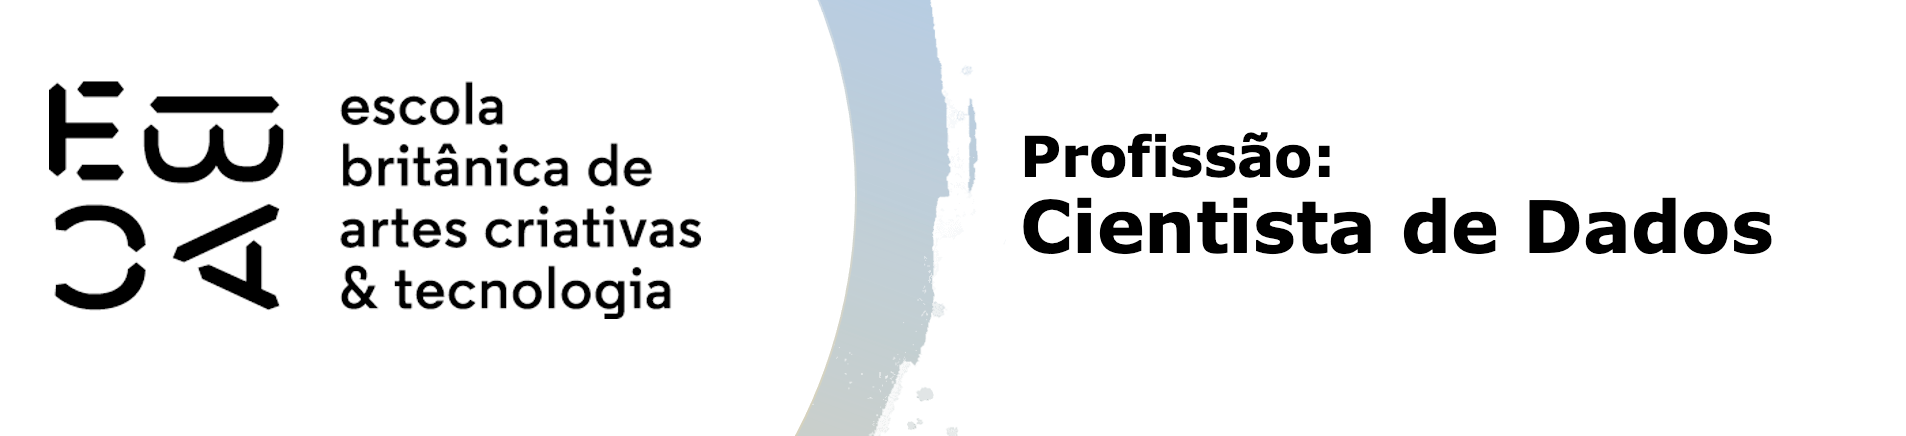

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t

import plotly.express as px

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_feather('../Dados/credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
df['data_ref'] = pd.to_datetime(df['data_ref'])
dates = sorted(df['data_ref'].unique())
oot_dates = dates[-3:]

df_train = df[~df['data_ref'].isin(oot_dates)].copy()
df_oot = df[df['data_ref'].isin(oot_dates)].copy()

print(f'Treino: {df_train["data_ref"].min()} a {df_train["data_ref"].max()}')
print(f'OOT: {df_oot["data_ref"].min()} a {df_oot["data_ref"].max()}')

Treino: 2015-01-01 00:00:00 a 2015-12-01 00:00:00
OOT: 2016-01-01 00:00:00 a 2016-03-01 00:00:00


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [4]:
print(df.shape)
print(df['data_ref'].value_counts().sort_index())

vars_quant = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
vars_qual = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

print(df[vars_quant].describe())

for var in vars_qual:
    print(df[var].value_counts())
    print('\n')

(750000, 15)
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64
               idade  tempo_emprego  qt_pessoas_residencia         renda
count  750000.000000  624043.000000          750000.000000  7.500000e+05
mean       43.804733       7.748574               2.212241  2.323854e+04
std        11.229868       6.687455               0.903428  7.910601e+04
min        22.000000       0.117808               1.000000  1.076700e+02
25%        34.000000       3.049315               2.000000  3.467700e+03
50%        43.000000       6.046575               2.000000  7.861820e+03
75%        53.000000      10.183562               3.000000  1.831828e+04
max        68.000000      42.906849              15.000000  4.083986

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

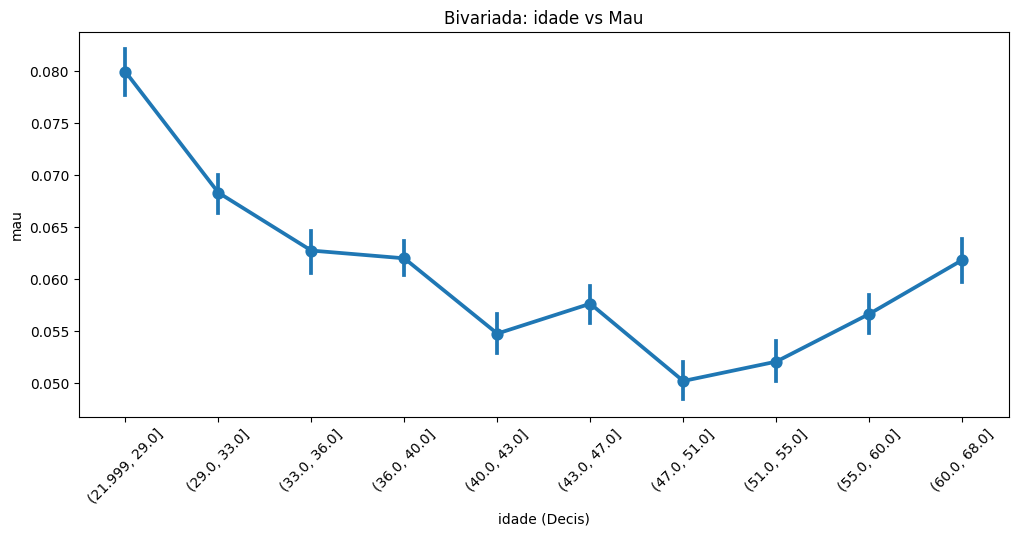

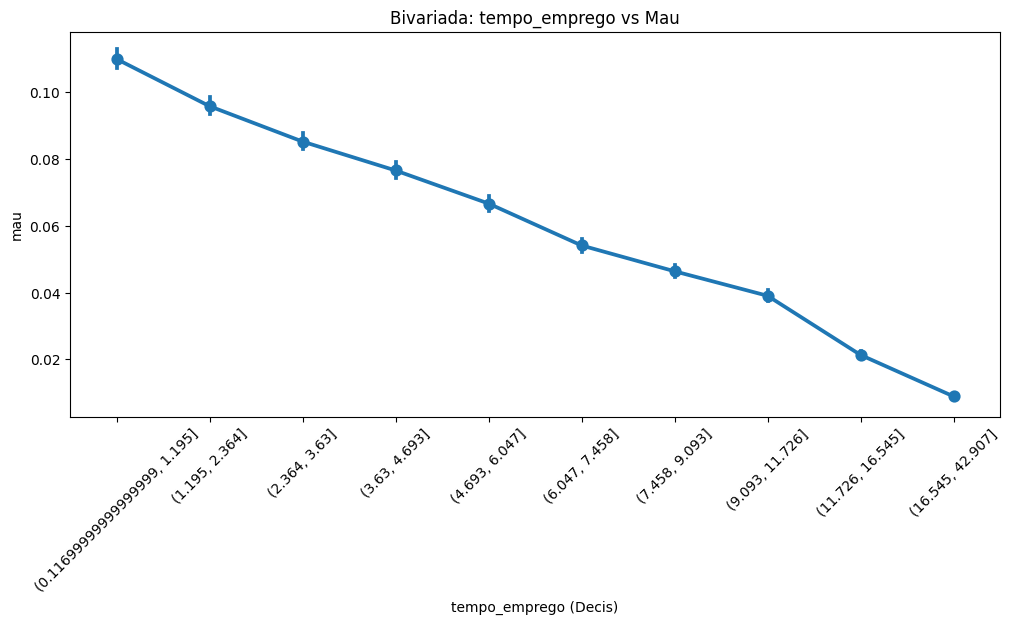

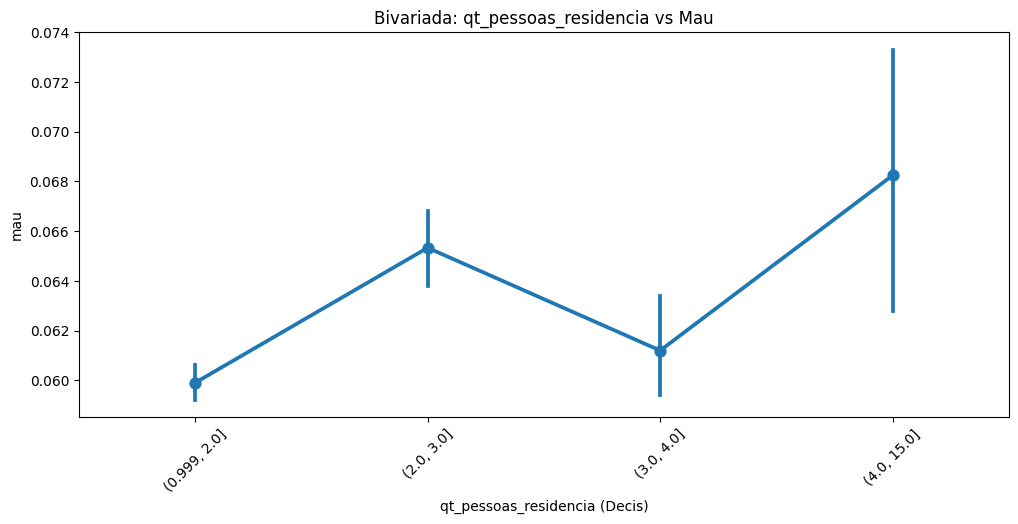

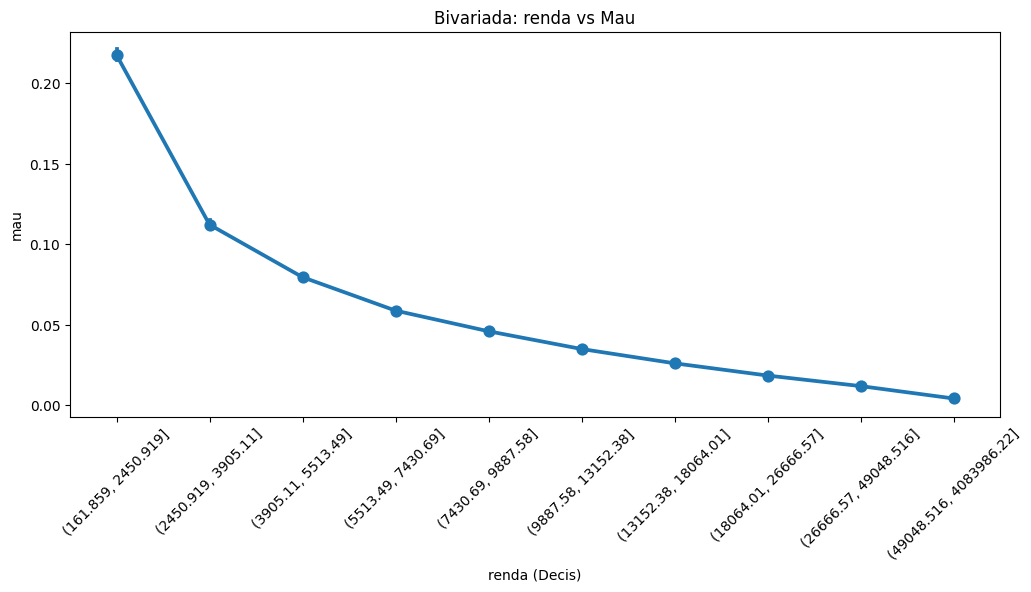

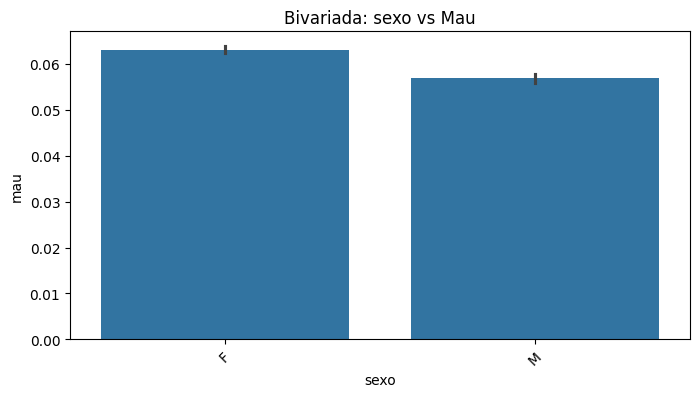

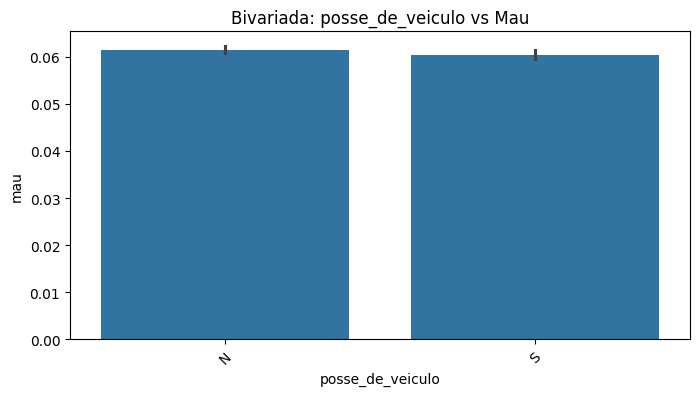

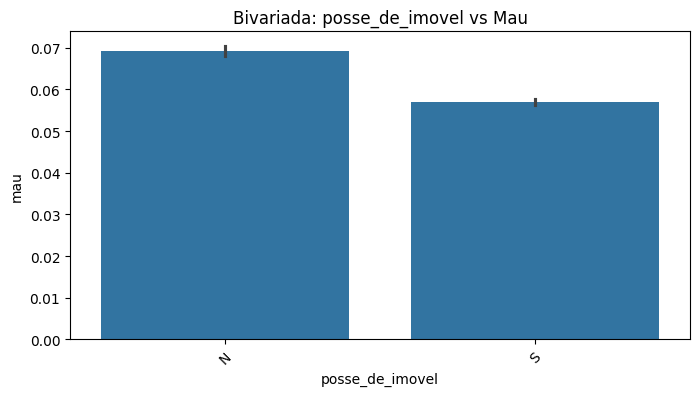

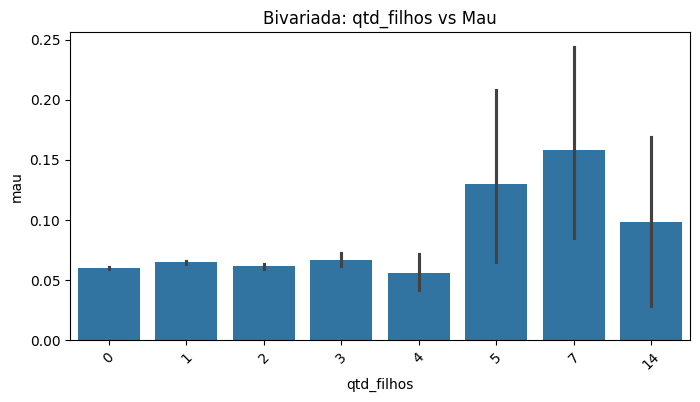

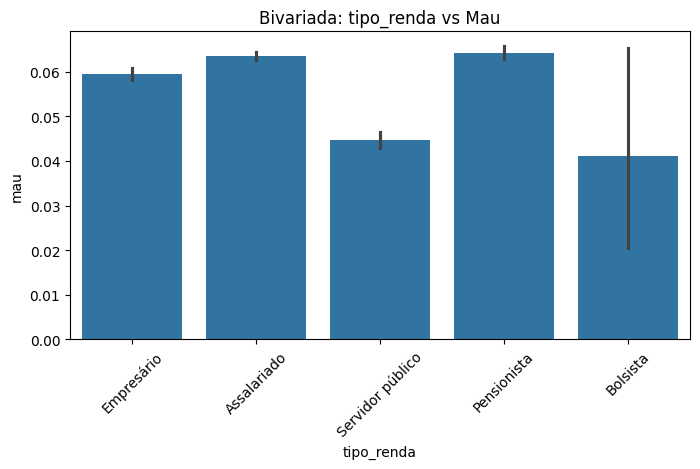

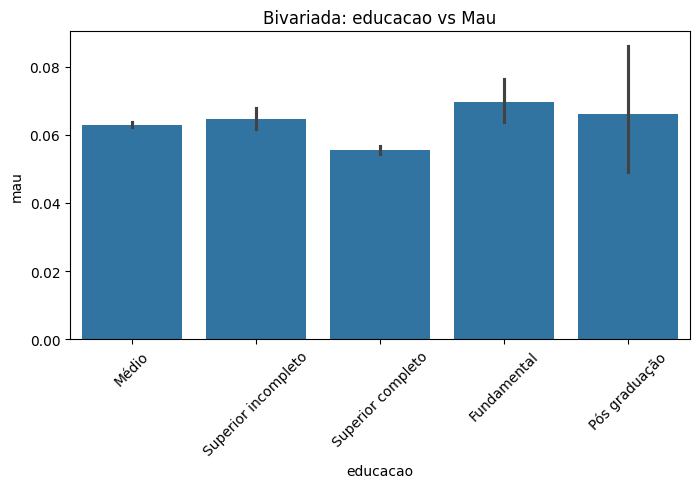

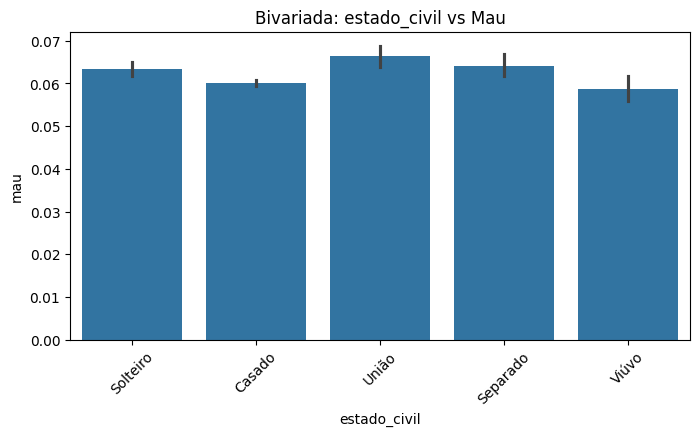

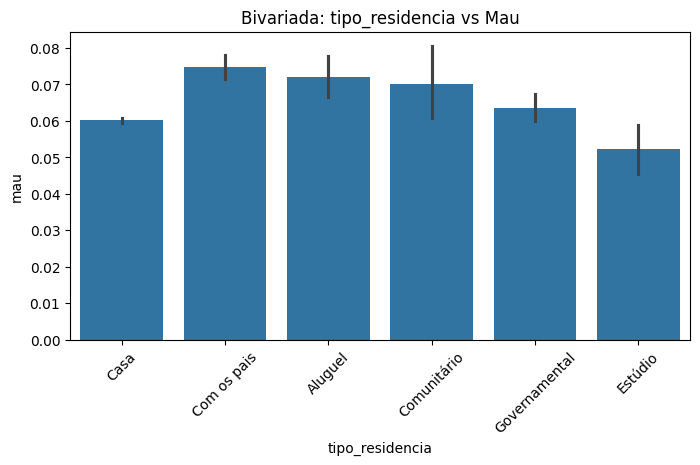

In [5]:
var_explicativas = vars_quant + vars_qual

for var in var_explicativas:
    if var in vars_quant:
        plt.figure(figsize=(12, 5))
        df_train['bin_var'] = pd.qcut(df_train[var], q=10, duplicates='drop')
        sns.pointplot(x='bin_var', y='mau', data=df_train)
        plt.xticks(rotation=45)
        plt.xlabel(f'{var} (Decis)')
        df_train.drop(columns=['bin_var'], inplace=True)
    else:
        plt.figure(figsize=(8, 4))
        sns.barplot(x=var, y='mau', data=df_train)
        plt.xticks(rotation=45)
    plt.title(f'Bivariada: {var} vs Mau')
    plt.show()

In [6]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

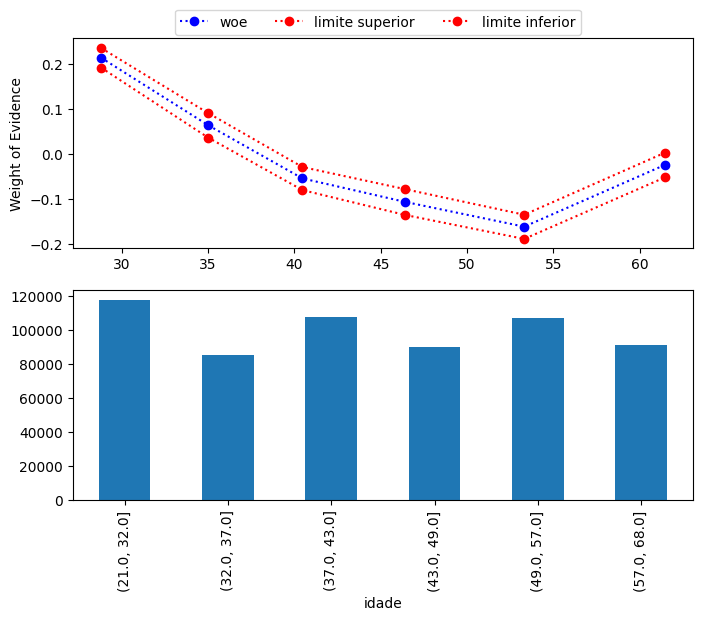

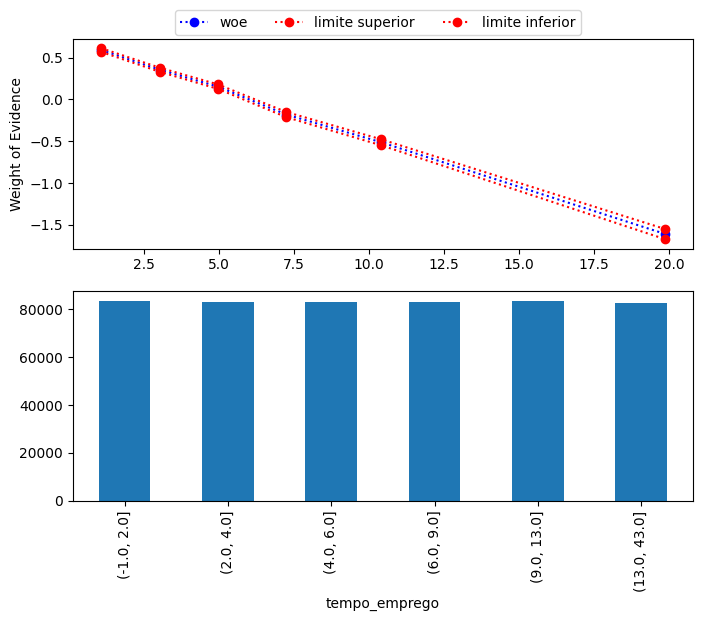

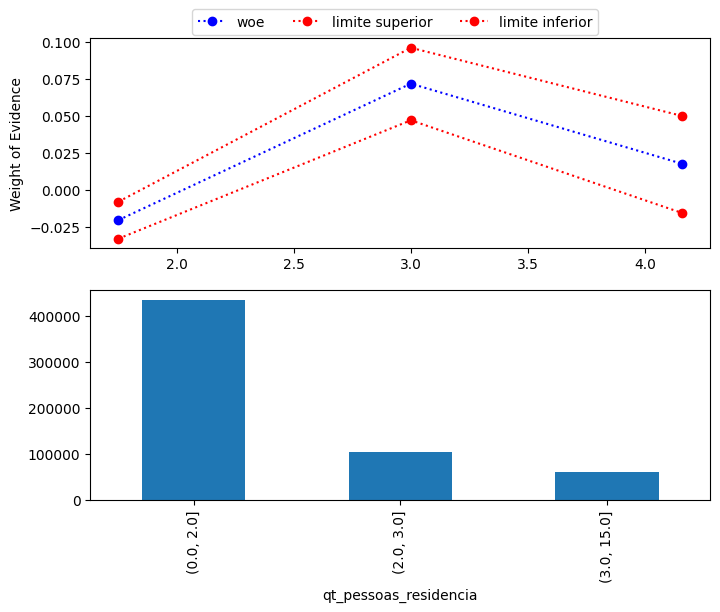

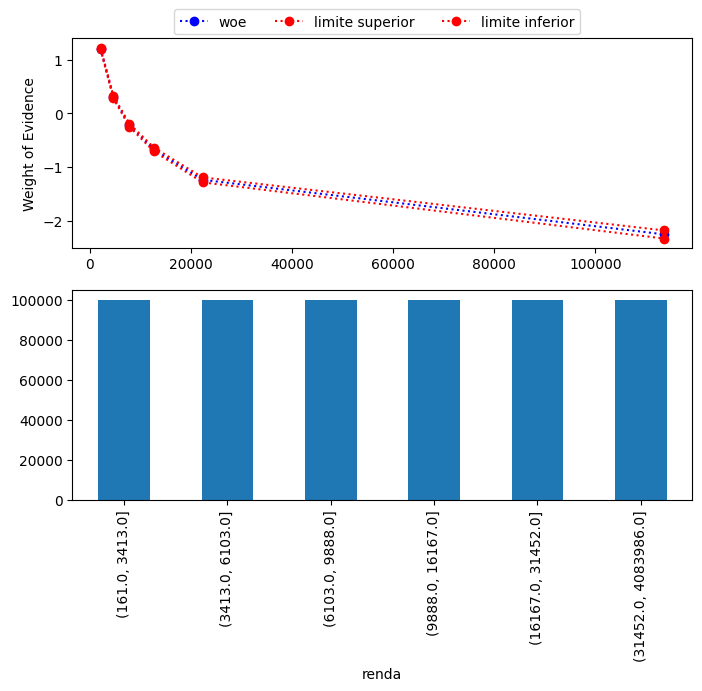

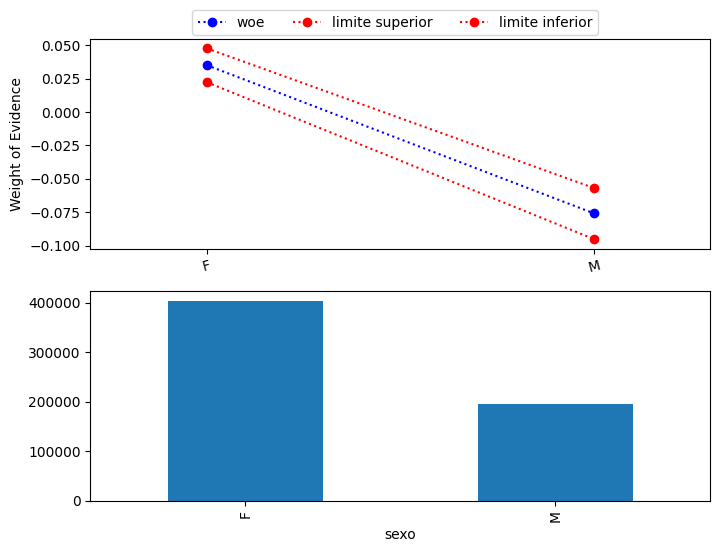

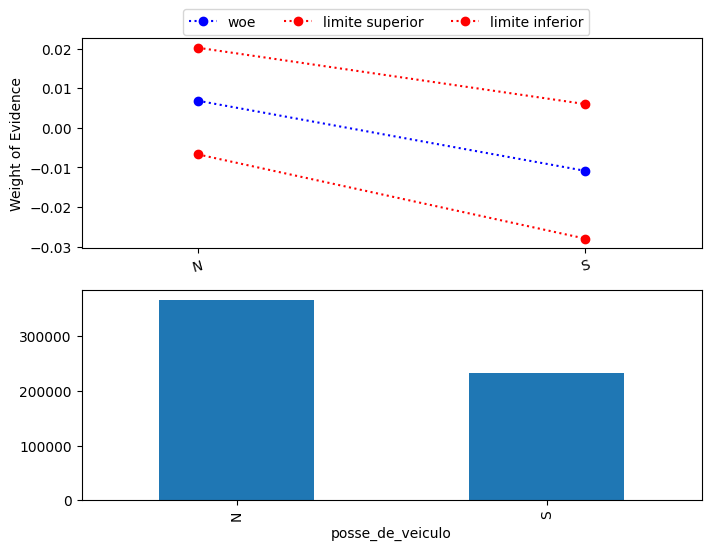

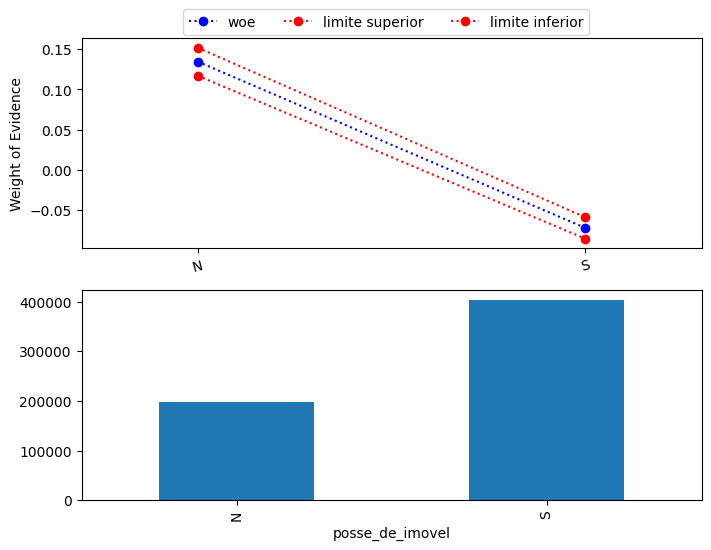

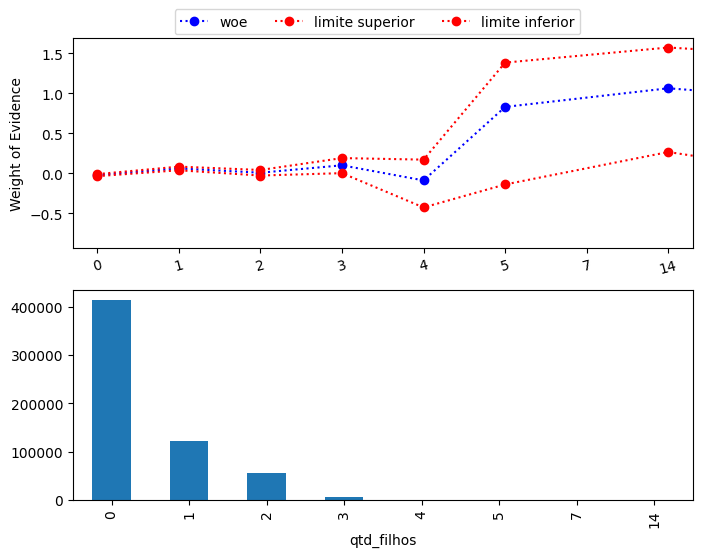

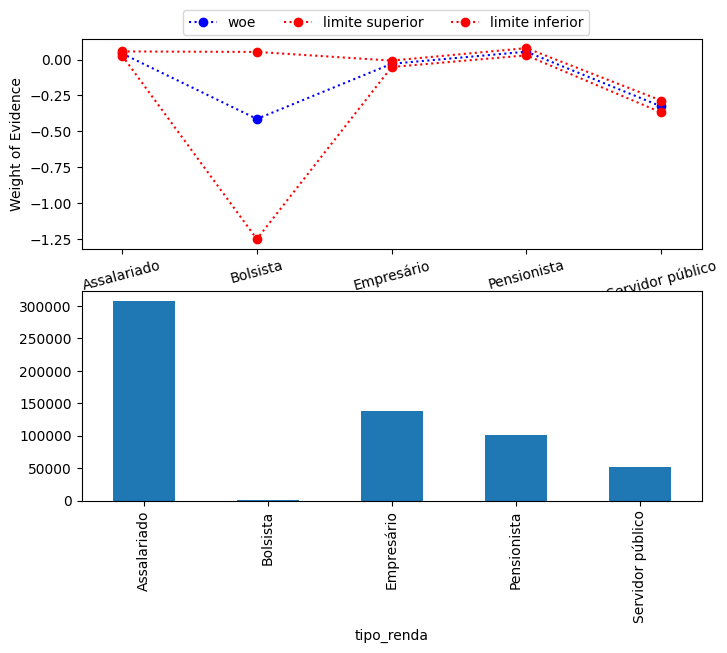

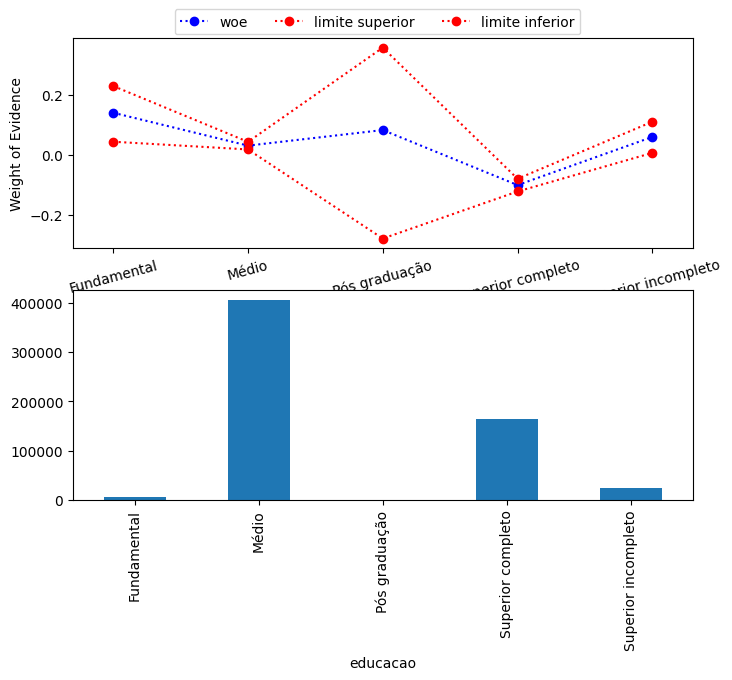

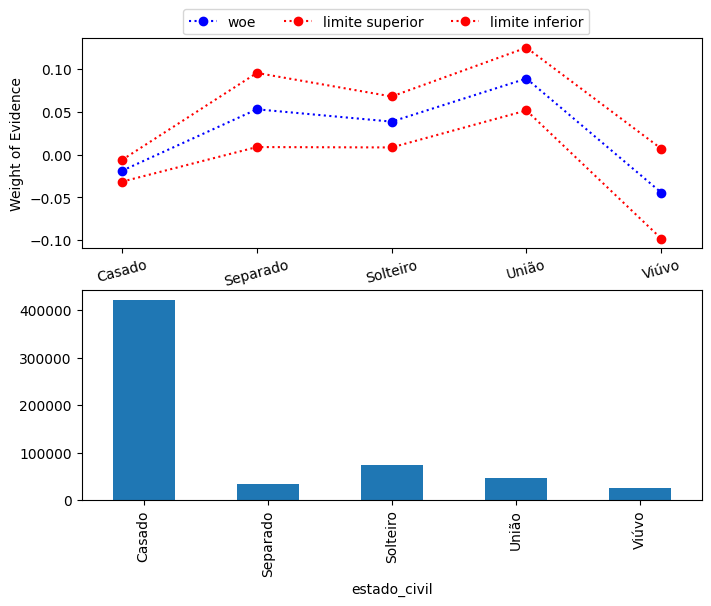

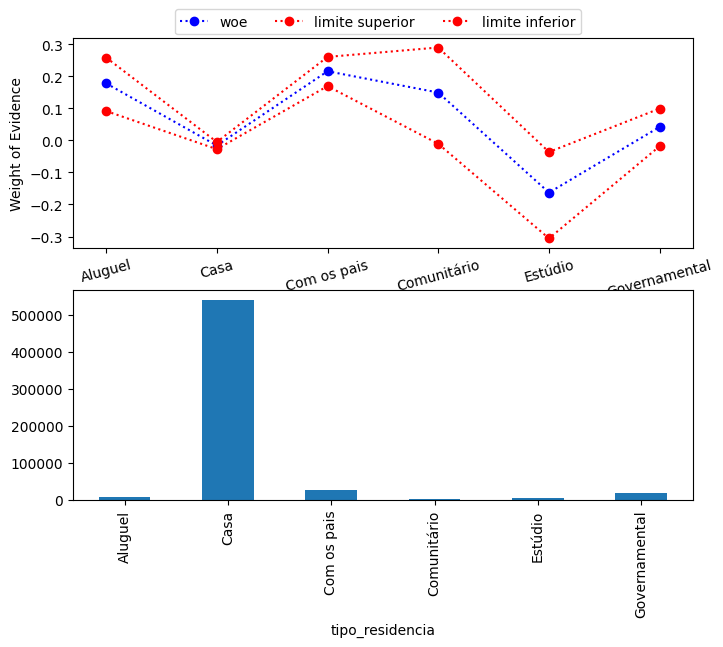

In [7]:
for var in var_explicativas:
    if var not in vars_quant:
        biv_discreta(var, df_train)
    else:
        biv_continua(var, 6, df_train)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [8]:
df['log_renda'] = np.log(df['renda'] + 1)
df['mau'] = df['mau'].astype(int)
df['tempo_emprego'] = df['tempo_emprego'].fillna(0)

df_train['mau'] = df_train['mau'].astype(int)
df_oot['mau'] = df_oot['mau'].astype(int)

df_train['tempo_emprego'] = df_train['tempo_emprego'].fillna(0)
df_oot['tempo_emprego'] = df_oot['tempo_emprego'].fillna(0)

df_train['log_renda'] = np.log(df_train['renda'] + 1)
df_oot['log_renda'] = np.log(df_oot['renda'] + 1)


formula = '''
mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + 
      tipo_renda + educacao + estado_civil + tipo_residencia + 
      idade + tempo_emprego + qt_pessoas_residencia + log_renda
'''

modelo = smf.glm(formula, data=df_train).fit()
print(modelo.summary())

formula_reduzida = '''
mau ~ posse_de_veiculo + posse_de_imovel + tempo_emprego + log_renda
'''

modelo_final = smf.glm(formula_reduzida, data=df_train).fit()
print(modelo_final.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599974
Model Family:                Gaussian   Df Model:                           25
Link Function:               Identity   Scale:                        0.054282
Method:                          IRLS   Log-Likelihood:                 22721.
Date:                Wed, 17 Dec 2025   Deviance:                       32568.
Time:                        18:00:12   Pearson chi2:                 3.26e+04
No. Iterations:                     3   Pseudo R-squ. (CS):            0.05486
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [9]:
taxa_de_default = df.mau.value_counts().loc[1] / df.mau.value_counts().sum()
print(f'Percentual de default: {taxa_de_default:.2%}')

Percentual de default: 7.82%


In [10]:
df['score'] = modelo_final.predict(df)
df_train['score'] = modelo_final.predict(df_train)
df_oot['score'] = modelo_final.predict(df_oot)


def avaliar_modelo(df):


# Acurácia
    acc = metrics.accuracy_score(df.mau, df.score>taxa_de_default)
#AUC
    fpr, tpr, thresholds = metrics.roc_curve(df.mau, df.score)
    auc = metrics.auc(fpr, tpr)
#Gini
    gini = 2*auc -1
    ks = ks_2samp(df.loc[df.mau == 1, 'score'], df.loc[df.mau != 1, 'score']).statistic

    print('\nAcurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
         .format(acc, auc, gini, ks))

In [11]:
avaliar_modelo(df_train)
avaliar_modelo(df_oot)


Acurácia: 64.7% 
AUC: 76.6% 
GINI: 53.2%
KS: 39.1%

Acurácia: 30.0% 
AUC: 73.4% 
GINI: 46.7%
KS: 33.9%


In [12]:
df3 = df.sort_values(by='score').reset_index().copy()
df3['tx_mau_acum'] = df3.mau.cumsum()/df3.shape[0]

df3['pct_mau_acum'] = df3.mau.cumsum()/df3.mau.sum()
df3['red_mau_acum'] = 1-df3.pct_mau_acum

df3['pct_aprovacao'] = np.array(range(df3.shape[0]))/df3.shape[0]
df3.head()

,level_0,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,...,tempo_emprego,qt_pessoas_residencia,renda,mau,log_renda,score,tx_mau_acum,pct_mau_acum,red_mau_acum,pct_aprovacao
0,329674,2015-07-01,8635,F,N,S,0,Assalariado,Superior completo,Solteiro,...,29.041096,1.0,3607412.81,0,15.098502,-0.19113,0.0,0.0,1.0,0.000000
1,309131,2015-07-01,8635,F,N,S,0,Assalariado,Superior completo,Solteiro,...,29.041096,1.0,3607412.81,0,15.098502,-0.19113,0.0,0.0,1.0,0.000001
2,338276,2015-07-01,8635,F,N,S,0,Assalariado,Superior completo,Solteiro,...,29.041096,1.0,3607412.81,0,15.098502,-0.19113,0.0,0.0,1.0,0.000003
3,301203,2015-07-01,8635,F,N,S,0,Assalariado,Superior completo,Solteiro,...,29.041096,1.0,3607412.81,0,15.098502,-0.19113,0.0,0.0,1.0,0.000004
4,322706,2015-07-01,8635,F,N,S,0,Assalariado,Superior completo,Solteiro,...,29.041096,1.0,3607412.81,0,15.098502,-0.19113,0.0,0.0,1.0,0.000005


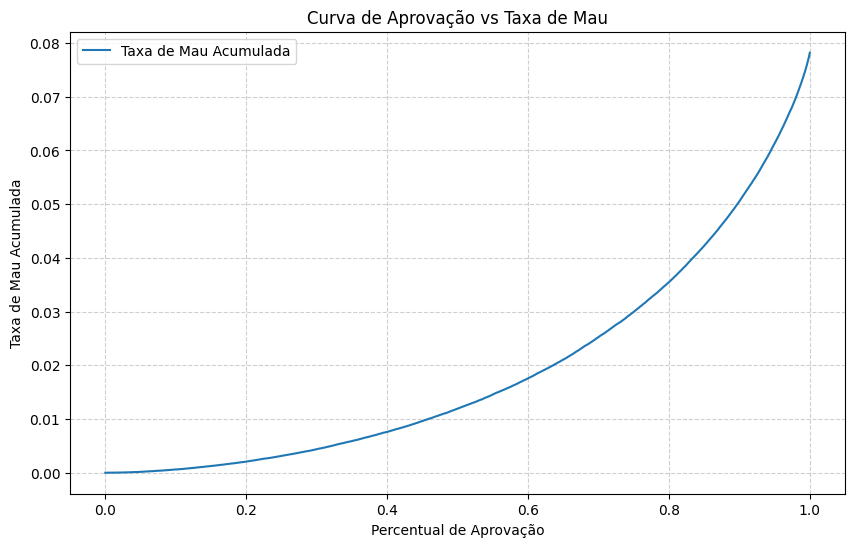

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(df3['pct_aprovacao'], df3['tx_mau_acum'], label='Taxa de Mau Acumulada')
plt.xlabel('Percentual de Aprovação')
plt.ylabel('Taxa de Mau Acumulada')
plt.title('Curva de Aprovação vs Taxa de Mau')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()